## For nicer formatting view, please go to:


## IS622: Week 10 Mini-Project (update)
### Clustering with PySpark
### Brian Chu | Nov. 18, 2015

**This is the PySpark implementation of k-means clustering for Meetup.com RSVP location data**

The dataset is the same streaming file used in Weeks 8 and 9.  
It is unique RSVP information for Meetup.com based on GPS coordinates, city, and country of responder, and Meetup group name.  
http://meetup.github.io/stream/rsvpTicker/

In [1]:
import os
import sys

# Path for Spark source folder
os.environ['SPARK_HOME']="/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6"

# Append pyspark to Python Path
sys.path.append("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/")

# Append py4j to Python Path
sys.path.append("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip")

In [2]:
# Launch Spark
execfile("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/pyspark/shell.py")

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 14 2015 16:09:02)
SparkContext available as sc, HiveContext available as sqlContext.


In [3]:
# Load required packages
from pyspark.sql import SQLContext
import numpy as np
import csv
import dateutils
import pyspark_csv as pycsv #https://github.com/seahboonsiew/pyspark-csv
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import data
raw = sc.textFile("meetup.csv")
type(raw)

# Convert raw csv data to Spark dataframe
sqlc = SQLContext(sc)
meetup = pycsv.csvToDataFrame(sqlc, raw)
meetup.show(5)

+----------+----------+-----------+-------+--------------------+
|       lat|      long|       city|country|               group|
+----------+----------+-----------+-------+--------------------+
| 42.346603| -71.10743|     Boston|     us|Greater Boston Pe...|
| 51.494598|  -0.10047|     London|     gb|London Digital An...|
|-33.761341|150.666107|     Sydney|     au|Sydney Kayaking M...|
| 49.232578| -123.1166|  Vancouver|     ca|The Vancouver Man...|
| 44.856516|-93.434491|Minneapolis|     us|Twin Cities Profe...|
+----------+----------+-----------+-------+--------------------+
only showing top 5 rows



In [5]:
# Subset US and scale data in Pandas
import pandas as pd
from sklearn.preprocessing import scale

pdf = meetup.toPandas()
pdfUS = pdf[(pdf.country=="us") & (pdf.long < -50)]
dfplot = sqlc.createDataFrame(pdfUS)

pdfUS_norm = pdfUS
pdfUS_norm.lat = scale(pdfUS_norm.iloc[:,0])
pdfUS_norm.long = scale(pdfUS_norm.iloc[:,1])

# Convert back to PySpark DF and subset GPS columns
df_norm = sqlc.createDataFrame(pdfUS_norm)
df_norm = df_norm["long", "lat"]
df_norm.show(3)

+-------------------+------------------+
|               long|               lat|
+-------------------+------------------+
|  1.306523253301959|0.9473386444772237|
|0.15292857847310476|1.4593321656122435|
|-1.2013698374901778|-0.112316408258129|
+-------------------+------------------+
only showing top 3 rows



### PySpark MLlib package for k-means clustering

Modified source code from:  
http://spark.apache.org/docs/latest/mllib-clustering.html

In [6]:
# Use PySpark MLlib package for k-means clustering

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

k = 5 # number of clusters (consistent with prior weeks)
dfk = df_norm.map(lambda row: array([float(x) for x in row]))
clusters = KMeans.train(dfk, k, maxIterations=10, seed=50)

The MLlib k-means function seems to assume labeled data in train/test format.  
Since we just want to do unsupervised learning on our dataset, we 'predict' over the entire data.

In [7]:
# Sample first 20 rows
clust = clusters.predict(dfk).take(dfk.count())

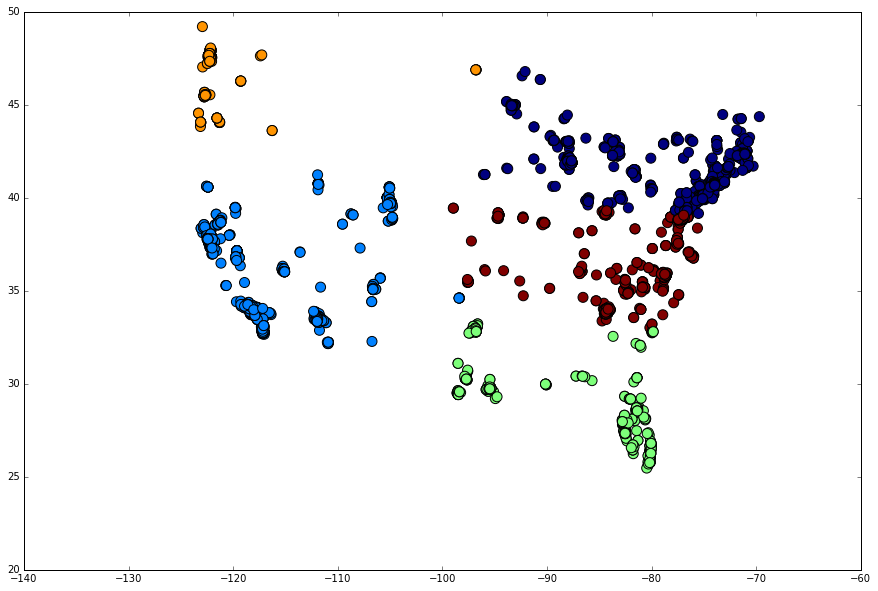

In [8]:
# Plot clusters
import matplotlib.pyplot as plt
%matplotlib inline

sqlCtx.registerDataFrameAsTable(dfplot, "gps")
dfk2 = sqlCtx.sql("SELECT long, lat from gps")
plt.figure(figsize=(15,10))
r = [(x,y) for x,y in dfk2.take(dfk2.count())]
x1 = [x for (x,y) in r]
y1 = [y for (x,y) in r]
plt.xlim([-140,-60])
plt.ylim([20,50])
plt.scatter(x1,y1, c=clust, s=100)

### Examine center points

In [9]:
# Convert back to original scale
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

pdfplot = pdf[(pdf.country=="us") & (pdf.long < -50)]
[x for x in pdfplot[["long", "lat"]]]
sslat = StandardScaler().fit(pdfplot["lat"])
sslong = StandardScaler().fit(pdfplot["long"])

# Put into Pandas DF
cc = pd.DataFrame(clusters.centers)
cc.columns = ["long", "lat"]
cc.long = sslong.inverse_transform(cc.iloc[:,0])
cc.lat = sslat.inverse_transform(cc.iloc[:,1])

In [10]:
cc.sort("long", ascending=False)

,long,lat
0,-78.381653,41.509402
4,-81.015102,37.073376
2,-88.187754,29.105460
1,-116.889558,36.136694
3,-122.005904,46.875027


The cluster center points are very close to the R k-means results than the RHadoop ones. Basically, PySpark MLlib is also not classifying Hawaii points as their own cluster, unlike the RHadoop implementation shown earlier.